In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer, make_column_transformer
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import OneHotEncoder


from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
from sklearn.metrics import auc, accuracy_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold, RandomizedSearchCV, train_test_split
from sklearn.metrics import roc_curve, auc,recall_score,precision_score, f1_score


# ignore the warnings
import warnings
warnings.filterwarnings('ignore')


Classification model with 100 features.
ASK: Create predictions on the data in test.csv using each of your trained models (using train.csv). The predictions should be the class probabilities for belonging to the positive class (labeled '1').

Approch: 
Step1: Clean and prepare data 
Step2: Build ml models using ml pipeline
step3: Compare the modeling approaches
step4: Present the results

In [2]:
#Function ROC curve
def plot_roc_curve(y_test, y_prediction):
    fpr, tpr, _ = roc_curve(y_test, y_prediction)
    roc_auc = auc(fpr, tpr)
    plt.figure()

    lw = 2
    plt.plot(fpr, tpr, color='darkorange',
             lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([-0.02, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve')
    plt.legend(loc="lower right")
    plt.show()

In [3]:
#Loading the data 
data_int=pd.read_csv("train.csv")

In [4]:
df=data_int.copy()

### Data Understanding 

In [5]:
df.head()

,y,x1,x2,x3,x4,x5,x6,x7,x8,x9,...,x91,x92,x93,x94,x95,x96,x97,x98,x99,x100
0,0,0.165254,18.060003,Wed,1.077380,-1.339233,-1.584341,0.0062%,0.220784,1.816481,...,-0.397427,0.909479,no,5.492487,NaN,10.255579,7.627730,0,yes,104.251338
1,1,2.441471,18.416307,Friday,1.482586,0.920817,-0.759931,0.0064%,1.192441,3.513950,...,0.656651,9.093466,no,3.346429,4.321172,NaN,10.505284,1,yes,101.230645
2,1,4.427278,19.188092,Thursday,0.145652,0.366093,0.709962,-8e-04%,0.952323,0.782974,...,2.059615,0.305170,no,4.456565,NaN,8.754572,7.810979,0,yes,109.345215
3,0,3.925235,19.901257,Tuesday,1.763602,-0.251926,-0.827461,-0.0057%,-0.520756,1.825586,...,0.899392,5.971782,no,4.100022,1.151085,NaN,9.178325,1,yes,103.021970
4,0,2.868802,22.202473,Sunday,3.405119,0.083162,1.381504,0.0109%,-0.732739,2.151990,...,3.003595,1.046096,yes,3.234033,2.074927,9.987006,11.702664,0,yes,92.925935


In [6]:
df.shape

(40000, 101)

In [7]:
df.columns

Index(['y', 'x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9',
       ...
       'x91', 'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x100'],
      dtype='object', length=101)

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Columns: 101 entries, y to x100
dtypes: float64(86), int64(3), object(12)
memory usage: 30.8+ MB


In [9]:
df.describe()


,y,x1,x2,x4,x5,x6,x8,x9,x10,x11,...,x89,x90,x91,x92,x94,x95,x96,x97,x98,x100
count,40000.000000,40000.000000,40000.000000,40000.000000,37572.000000,40000.000000,40000.000000,40000.000000,40000.000000,34890.000000,...,29309.000000,40000.000000,34741.000000,37565.000000,37660.000000,27396.000000,33362.000000,40000.000000,40000.000000,40000.000000
mean,0.145075,2.999958,20.004865,0.002950,0.005396,0.007234,0.004371,2.722334,0.490339,100.008988,...,10.767838,3.000166,0.001636,4.002896,3.969385,0.031886,10.525530,10.002814,0.497650,100.024743
std,0.352181,1.994490,1.604291,1.462185,1.297952,1.358551,1.447223,1.966828,1.029863,13.343010,...,3.732763,1.164411,1.468790,3.017420,1.473939,1.823091,1.437581,1.986984,0.500001,5.247514
min,0.000000,-3.648431,13.714945,-5.137161,-5.616412,-6.113153,-6.376810,-3.143438,-3.538129,50.526543,...,6.106024,-2.173310,-6.328126,-3.384399,-1.663063,-6.885150,8.210456,1.911272,0.000000,78.340735
25%,0.000000,1.592714,18.921388,-1.026798,-0.872354,-0.909831,-0.971167,1.340450,-0.207833,91.056682,...,7.927605,2.211125,-0.982679,1.610899,2.943758,-1.190682,9.397548,8.665103,0.000000,96.516856
50%,0.000000,2.875892,20.005944,0.002263,0.008822,0.007335,0.002226,2.498876,0.486926,100.020965,...,9.931831,2.998776,0.005664,4.099763,3.912526,0.001523,10.358355,9.994318,0.000000,100.024977
75%,0.000000,4.270295,21.083465,1.043354,0.892467,0.926222,0.985023,3.827712,1.182994,109.025025,...,12.710543,3.786751,0.989632,6.113157,4.930563,1.248742,11.448559,11.342574,1.000000,103.558762
max,1.000000,13.837591,27.086468,5.150153,5.698128,5.639372,5.869889,18.006669,4.724186,148.784484,...,38.566041,7.130058,6.868747,16.734658,11.669024,7.631773,18.725468,17.861580,1.000000,122.406809


In [10]:
#Categorical and Numeric variable list
category_list=[]
num_list=[]
for col in df.columns:
    if df[col].dtype=='object':
        category_list.append(col)
    else:
        num_list.append(col)
        
        
        

In [11]:
num_var=df[num_list]

describe = num_var.describe().T
describe['range'] = (num_var.max() - num_var.min()).tolist()
describe['variation coefficient'] = (num_var.std() / num_var.mean()).tolist()
describe['skew'] = num_var.skew().tolist()
describe['kurtosis'] = num_var.kurtosis().tolist()
describe

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
y,40000.0,0.145075,0.352181,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.427578,2.015685,2.063088
x1,40000.0,2.999958,1.994490,-3.648431,1.592714,2.875892,4.270295,13.837591,17.486022,0.664839,0.382880,0.198652
x2,40000.0,20.004865,1.604291,13.714945,18.921388,20.005944,21.083465,27.086468,13.371523,0.080195,0.010218,-0.005302
x4,40000.0,0.002950,1.462185,-5.137161,-1.026798,0.002263,1.043354,5.150153,10.287314,495.650951,0.007023,-0.328269
x5,37572.0,0.005396,1.297952,-5.616412,-0.872354,0.008822,0.892467,5.698128,11.314540,240.536141,-0.005447,-0.001788
...,...,...,...,...,...,...,...,...,...,...,...,...
x95,27396.0,0.031886,1.823091,-6.885150,-1.190682,0.001523,1.248742,7.631773,14.516923,57.175635,0.049023,0.009103
x96,33362.0,10.525530,1.437581,8.210456,9.397548,10.358355,11.448559,18.725468,10.515012,0.136580,0.632746,0.118909
x97,40000.0,10.002814,1.986984,1.911272,8.665103,9.994318,11.342574,17.861580,15.950308,0.198642,0.019503,0.037706
x98,40000.0,0.497650,0.500001,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.004724,0.009400,-2.000012


In [12]:
#Check for duplicate rows
df.duplicated().sum()

0

In [13]:
# Check for null Values
df.isnull().sum().sum()

373613

# Data cleaning and evaluation

### Null Value Columns analysis 

In [14]:
cols=df.columns[df.isna().any()]
for col in cols:
    miss_val=df[col].isnull().sum()
    per_val=miss_val/len(df[col])
    if per_val*100>0:
        print( df[col].dtype, '--->',col,"=", miss_val , "and percent" ,round(per_val*100,2),"%" )
    

float64 ---> x5 = 2428 and percent 6.07 %
float64 ---> x11 = 5110 and percent 12.78 %
float64 ---> x14 = 9864 and percent 24.66 %
float64 ---> x16 = 11212 and percent 28.03 %
float64 ---> x22 = 2387 and percent 5.97 %
object ---> x24 = 3856 and percent 9.64 %
float64 ---> x26 = 2433 and percent 6.08 %
float64 ---> x30 = 32336 and percent 80.84 %
object ---> x33 = 7171 and percent 17.93 %
float64 ---> x38 = 2402 and percent 6.0 %
float64 ---> x41 = 9503 and percent 23.76 %
float64 ---> x42 = 9729 and percent 24.32 %
float64 ---> x44 = 34247 and percent 85.62 %
float64 ---> x45 = 8009 and percent 20.02 %
float64 ---> x49 = 12823 and percent 32.06 %
float64 ---> x52 = 16182 and percent 40.46 %
float64 ---> x54 = 12728 and percent 31.82 %
float64 ---> x55 = 17696 and percent 44.24 %
float64 ---> x57 = 32464 and percent 81.16 %
float64 ---> x61 = 7293 and percent 18.23 %
float64 ---> x63 = 2420 and percent 6.05 %
float64 ---> x64 = 5101 and percent 12.75 %
float64 ---> x67 = 2425 and percen

In [15]:
# above 60% missing data in x30, x44,x57--drop the columns
#df.drop(['x30','x44','x57'], axis=1, inplace=True)

In [16]:
df.columns[df.isna().any()]

Index(['x5', 'x11', 'x14', 'x16', 'x22', 'x24', 'x26', 'x30', 'x33', 'x38',
       'x41', 'x42', 'x44', 'x45', 'x49', 'x52', 'x54', 'x55', 'x57', 'x61',
       'x63', 'x64', 'x67', 'x68', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79',
       'x80', 'x83', 'x85', 'x86', 'x88', 'x89', 'x91', 'x92', 'x94', 'x95',
       'x96', 'x99'],
      dtype='object')

In [17]:
df.dtypes.value_counts()

float64    86
object     12
int64       3
dtype: int64

#### Categorical Variables

In [18]:
df_cat=df.select_dtypes(include=['object'])
df_cat.nunique()

x3        14
x7       663
x19    40000
x24        2
x31        2
x33       51
x39        1
x60       12
x65        5
x77        7
x93        2
x99        1
dtype: int64

In [19]:
df_cat.head()

,x3,x7,x19,x24,x31,x33,x39,x60,x65,x77,x93,x99
0,Wed,0.0062%,$-908.650758424405,female,no,Colorado,5-10 miles,August,farmers,mercedes,no,yes
1,Friday,0.0064%,$-1864.9622875143,male,no,Tennessee,5-10 miles,April,allstate,mercedes,no,yes
2,Thursday,-8e-04%,$-543.187402955527,male,no,Texas,5-10 miles,September,geico,subaru,no,yes
3,Tuesday,-0.0057%,$-182.626380634258,male,no,Minnesota,5-10 miles,September,geico,nissan,no,yes
4,Sunday,0.0109%,$967.007090837503,male,yes,New York,5-10 miles,January,geico,toyota,yes,yes


In [20]:
df_cat.columns[df_cat.isna().any()]

Index(['x24', 'x33', 'x77', 'x99'], dtype='object')

In [21]:
df_cat['x3'].value_counts(dropna=False, normalize=True)*100
#Need to merge same day in different format

Wednesday    12.3250
Monday       10.3600
Friday        9.9375
Tuesday       9.7875
Sunday        9.0250
Saturday      8.9900
Tue           7.3700
Thursday      6.9775
Mon           5.5000
Wed           5.1075
Sat           4.4675
Thur          4.1075
Fri           4.0500
Sun           1.9950
Name: x3, dtype: float64

In [22]:
#DF map/ replace Mon, Tue etc., to Monday, Tuesday 
#df['x3']=df['x3'].replace(['Mon','Tue', 'Wed','Thur','Fri','Sat','Sun'],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday',
#                            'Sunday'])

In [23]:
df_cat['x7'].unique()[:20]
# remove ''%'' and convert the column to float

array(['0.0062%', '0.0064%', '-8e-04%', '-0.0057%', '0.0109%', '0.0079%',
       '0.0174%', '-0.0106%', '0.0032%', '0.0091%', '-0.0052%',
       '-0.0025%', '-0.0045%', '0.0068%', '-0.0137%', '-0.0014%',
       '-0.0013%', '0.0066%', '0.0097%', '-0.0086%'], dtype=object)

In [24]:
#df['x7']= df['x7'].str.replace('%', "").astype('float64')

In [25]:
df_cat['x19'].unique()
# remove '$' and convert the column to float

array(['$-908.650758424405', '$-1864.9622875143', '$-543.187402955527',
       ..., '$834.95775080472', '$-48.1031003332715', '$96.0017151741518'],
      dtype=object)

In [26]:
#df['x19']= df['x19'].str.replace('$', "").astype('float64')

In [27]:
df_cat['x24'].unique()

array(['female', 'male', nan], dtype=object)

female    45.395
male      44.965
NaN        9.640
Name: x24, dtype: float64


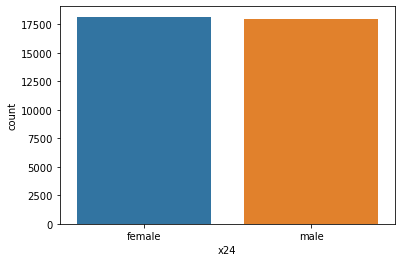

In [28]:
sns.countplot(data=df_cat, x="x24")
print(df_cat['x24'].value_counts(dropna=False, normalize=True)*100)
# need to imput/fill NaN values and apply OneHotEncoding 

In [29]:
# gender=df['x24'].mode()
# df["x24"]=df["x24"].fillna(gender)

In [30]:
# df_cat['x31'].value_counts(dropna=False, normalize=True)*100
# #need to apply OneHotEncoding

In [31]:
df_cat['x33'].value_counts(dropna=False, normalize=True)*100
# need to imput/fill NaN values and apply OneHotEncoding 

NaN               17.9275
California         8.4825
Texas              5.6300
Florida            4.5050
New York           4.2850
Illinois           3.1000
Pennsylvania       3.0825
Ohio               2.7850
Michigan           2.4550
Georgia            2.2950
North Carolina     2.2750
New Jersey         2.1750
Virginia           1.9775
Washington         1.8750
Tennessee          1.7250
Indiana            1.6850
Arizona            1.6625
Massachusetts      1.5950
Wisconsin          1.5875
Missouri           1.5850
Minnesota          1.5275
Maryland           1.4525
Alabama            1.3850
Colorado           1.3250
Louisiana          1.2525
South Carolina     1.2275
Kentucky           1.1950
Oregon             1.1300
Connecticut        1.0550
Oklahoma           0.9925
Kansas             0.9450
Nevada             0.9325
Utah               0.9250
Mississippi        0.9025
Iowa               0.8825
Arkansas           0.8650
New Mexico         0.8325
Nebraska           0.8075
West Virgini

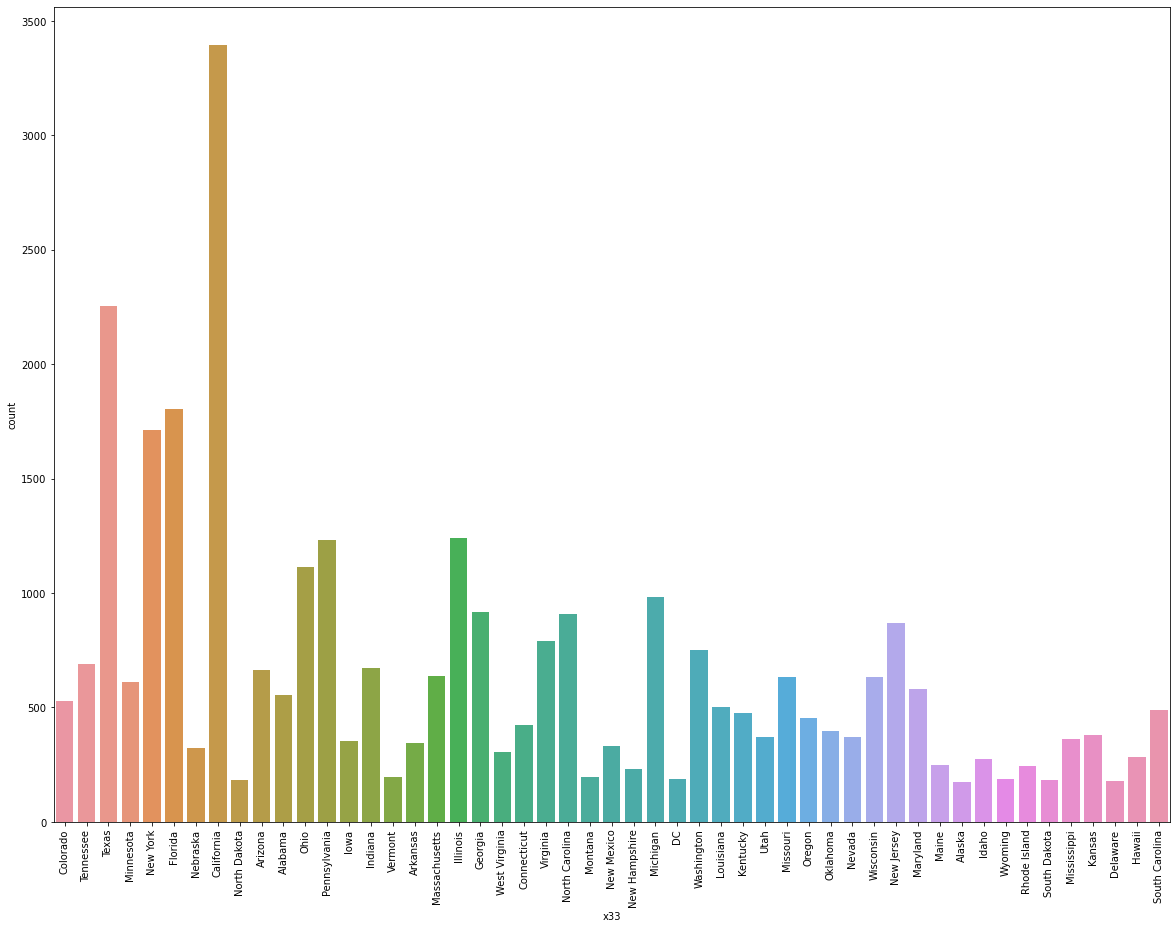

In [32]:
plt.figure(figsize=(20,15))
chart=sns.countplot(data=df_cat, x="x33")
chart.set_xticklabels(chart.get_xticklabels(),rotation=90)
plt.show()

In [33]:
df_cat['x39'].value_counts(dropna=False, normalize=True)*100
# no variance- drop this column 

5-10 miles    100.0
Name: x39, dtype: float64

In [34]:
df_cat['x60'].value_counts(dropna=False, normalize=True)*100
# need to apply OneHotEncoding 

December     20.3400
January      19.8050
July         19.7800
August       19.7675
June          3.1800
September     3.1125
February      3.0325
November      2.6075
April         2.3775
March         2.0175
May           1.9975
October       1.9825
Name: x60, dtype: float64

In [35]:
df_cat['x65'].value_counts(dropna=False, normalize=True)*100
# need to apply OneHotEncoding 

progressive    27.1925
allstate       27.1475
esurance       17.8600
farmers        14.0000
geico          13.8000
Name: x65, dtype: float64

In [36]:
df_cat['x77'].value_counts(dropna=False, normalize=True)*100
# need to impute/fill NaN and apply OneHotEncoding 

NaN          23.1425
ford         22.5125
subaru       12.6175
chevrolet    12.5275
mercedes     11.2350
toyota        8.8875
nissan        6.4375
buick         2.6400
Name: x77, dtype: float64

In [37]:
df_cat['x93'].value_counts(dropna=False, normalize=True)*100
# need to apply OneHotEncoding 

no     88.765
yes    11.235
Name: x93, dtype: float64

In [38]:
df_cat['x99'].unique()


array(['yes', nan], dtype=object)

In [39]:
df_cat['x99'].value_counts(dropna=False, normalize=True)*100
# not useful for analysis as no variation in column

yes    67.91
NaN    32.09
Name: x99, dtype: float64

# # Numeric Variables 

In [40]:
df_num=df.select_dtypes(exclude=['object'])
df_num

,y,x1,x2,x4,x5,x6,x8,x9,x10,x11,...,x89,x90,x91,x92,x94,x95,x96,x97,x98,x100
0,0,0.165254,18.060003,1.077380,-1.339233,-1.584341,0.220784,1.816481,1.171788,109.626841,...,10.602395,2.770844,-0.397427,0.909479,5.492487,NaN,10.255579,7.627730,0,104.251338
1,1,2.441471,18.416307,1.482586,0.920817,-0.759931,1.192441,3.513950,1.419900,84.079367,...,10.408146,3.703013,0.656651,9.093466,3.346429,4.321172,NaN,10.505284,1,101.230645
2,1,4.427278,19.188092,0.145652,0.366093,0.709962,0.952323,0.782974,-1.247022,95.375221,...,NaN,3.997183,2.059615,0.305170,4.456565,NaN,8.754572,7.810979,0,109.345215
3,0,3.925235,19.901257,1.763602,-0.251926,-0.827461,-0.520756,1.825586,2.223038,96.420382,...,NaN,2.933707,0.899392,5.971782,4.100022,1.151085,NaN,9.178325,1,103.021970
4,0,2.868802,22.202473,3.405119,0.083162,1.381504,-0.732739,2.151990,-0.275406,90.769952,...,NaN,2.922302,3.003595,1.046096,3.234033,2.074927,9.987006,11.702664,0,92.925935
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
39995,0,1.593480,19.628352,0.794697,-0.825849,0.608774,2.183834,3.202119,-0.723356,94.820410,...,NaN,3.017092,-1.640259,5.051545,5.798509,NaN,10.854903,9.505529,1,98.855726
39996,0,1.708685,17.132638,-2.676659,1.153851,0.465905,-0.048613,3.989567,1.468074,115.785563,...,8.706170,4.406889,-0.195783,2.020510,5.285345,-1.408117,8.867221,9.077493,0,101.880335
39997,0,1.704132,17.824399,-0.581360,NaN,0.467339,0.904643,2.975563,0.228908,107.939412,...,7.275794,4.537489,-0.071581,6.250353,4.729509,-1.118486,12.244620,7.663763,1,100.022536
39998,0,3.963408,20.285597,0.430116,0.050189,1.821565,-0.401259,-0.247649,-0.499294,93.314126,...,NaN,4.724964,-1.248535,8.928009,6.803781,NaN,9.876172,8.644538,0,109.460219


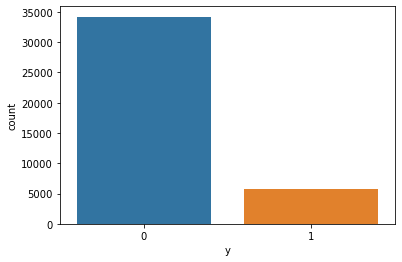

0    85.4925
1    14.5075
Name: y, dtype: float64


In [41]:
sns.countplot(data=df_num, x="y")
plt.show()
# Target variable is biased
print(df_num['y'].value_counts(normalize=True)*100)


In [42]:
#Correlation between the features wrt y to find the features that are closely correlated
cor = df_num.corr()
cor[['y']]

,y
y,1.000000
x1,0.012335
x2,0.008695
x4,-0.003196
x5,-0.022691
...,...
x95,0.045970
x96,-0.050843
x97,0.007611
x98,-0.010771


In [43]:
num_list=df_num.columns
#num_list

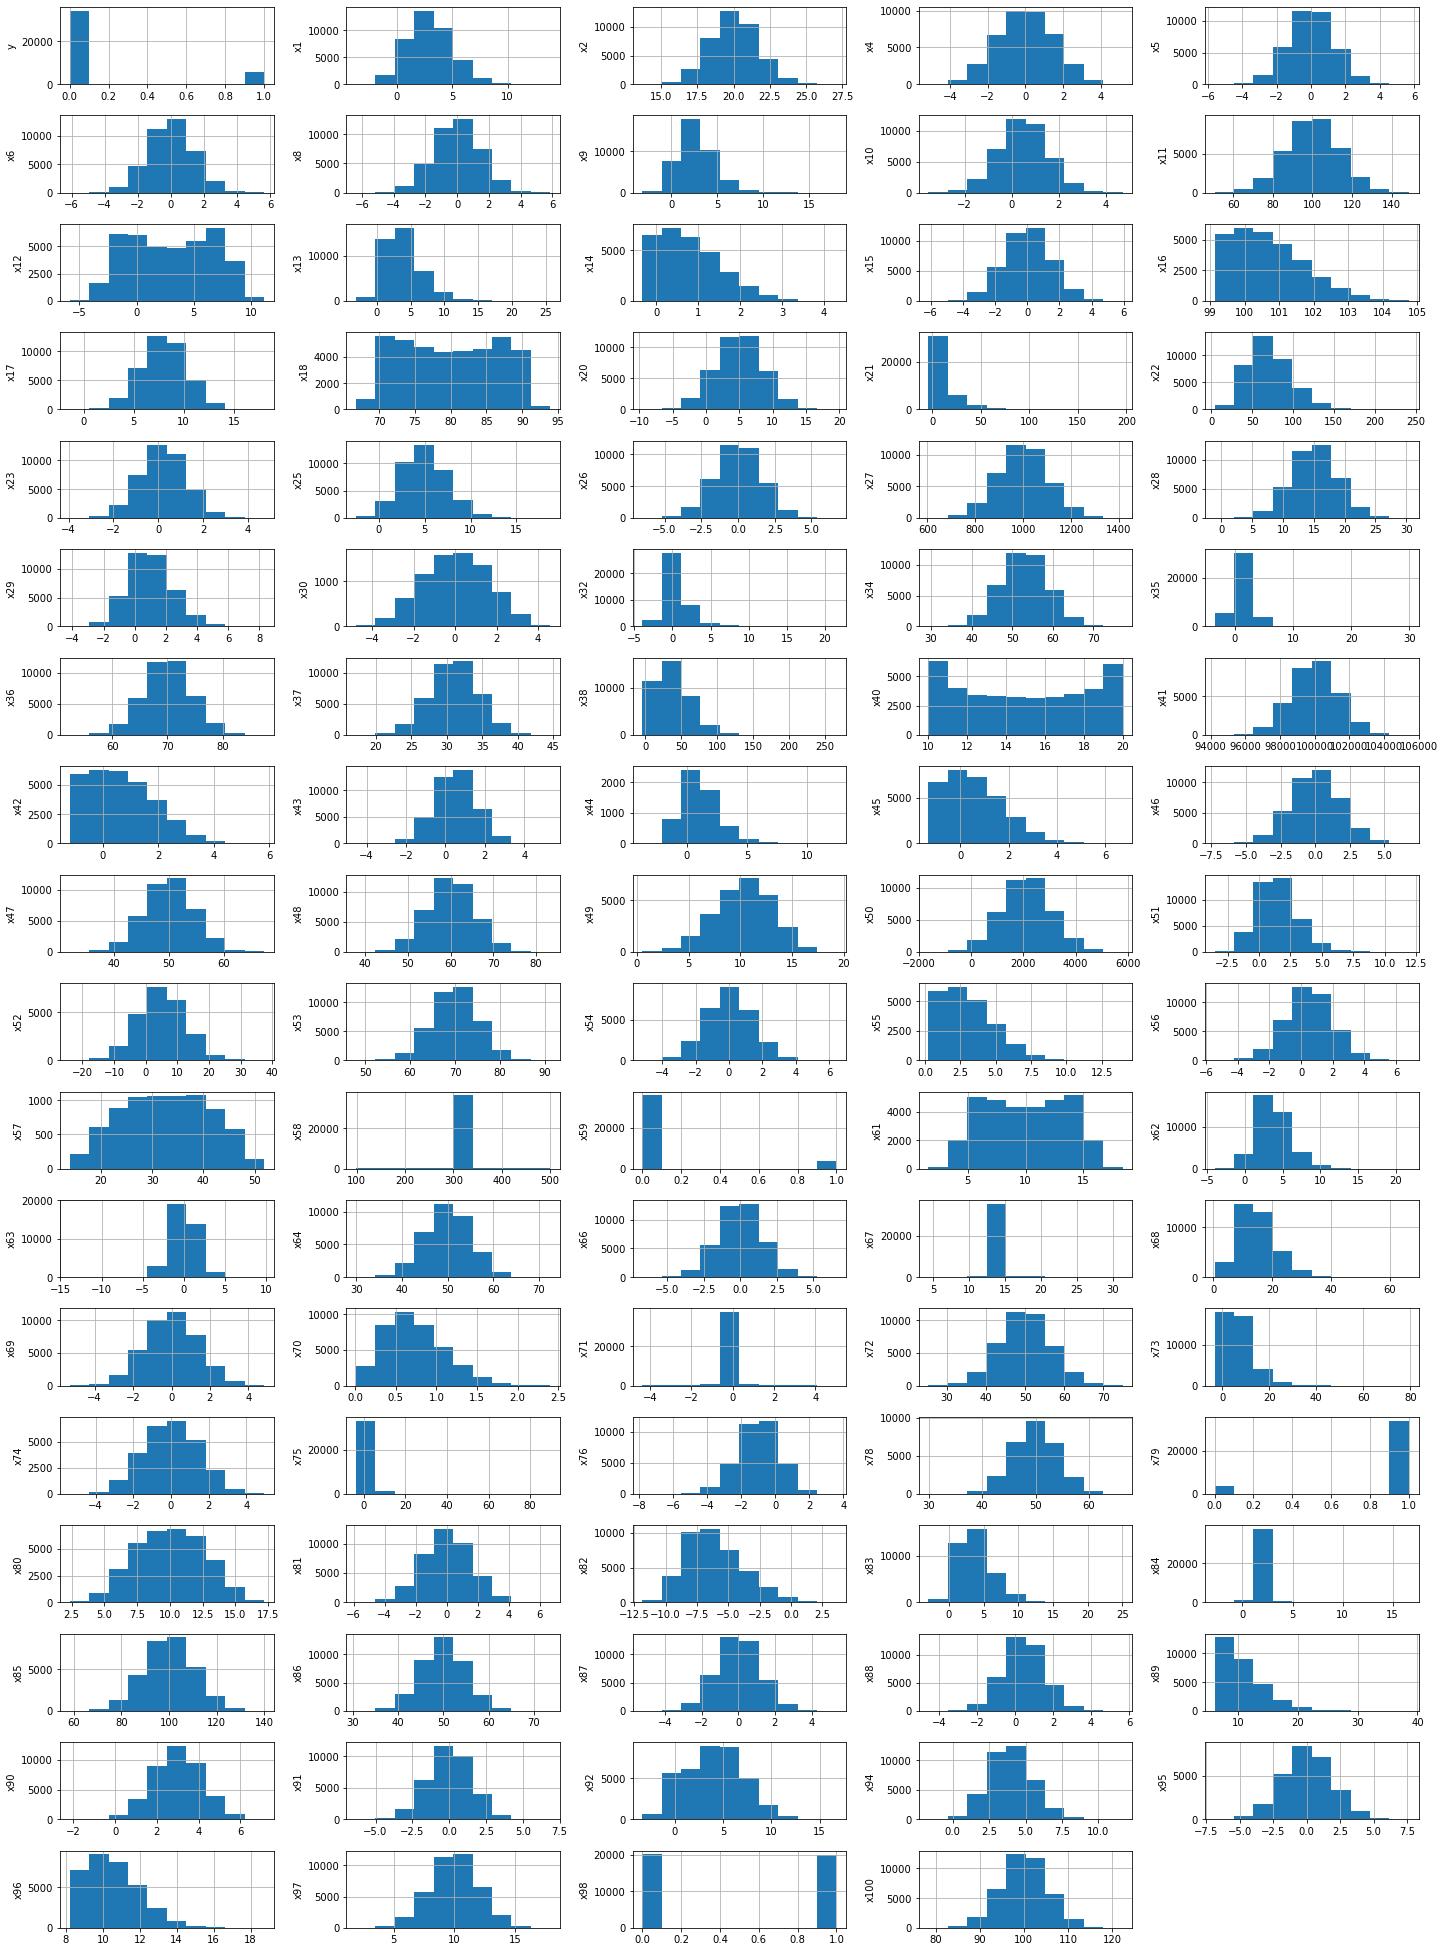

In [44]:
plt.figure(figsize=(20,30))

for i, col in zip(range(1,100), num_list):
    plt.subplot(20,5,i)
    plt.ylabel(col)
    df_num[col].hist()
               
plt.tight_layout()
plt.show()



In [45]:
# from above plots its evident that some of the columns has only 2 unique values
for i in df_num.columns[(df_num.nunique())<3]:
    print(i,"=", df_num[i].unique()) # "\nval","\n",df_num[i].value_counts(dropna=False, normalize=True)*100)
    

y = [0 1]
x59 = [0 1]
x79 = [ 1. nan  0.]
x98 = [0 1]


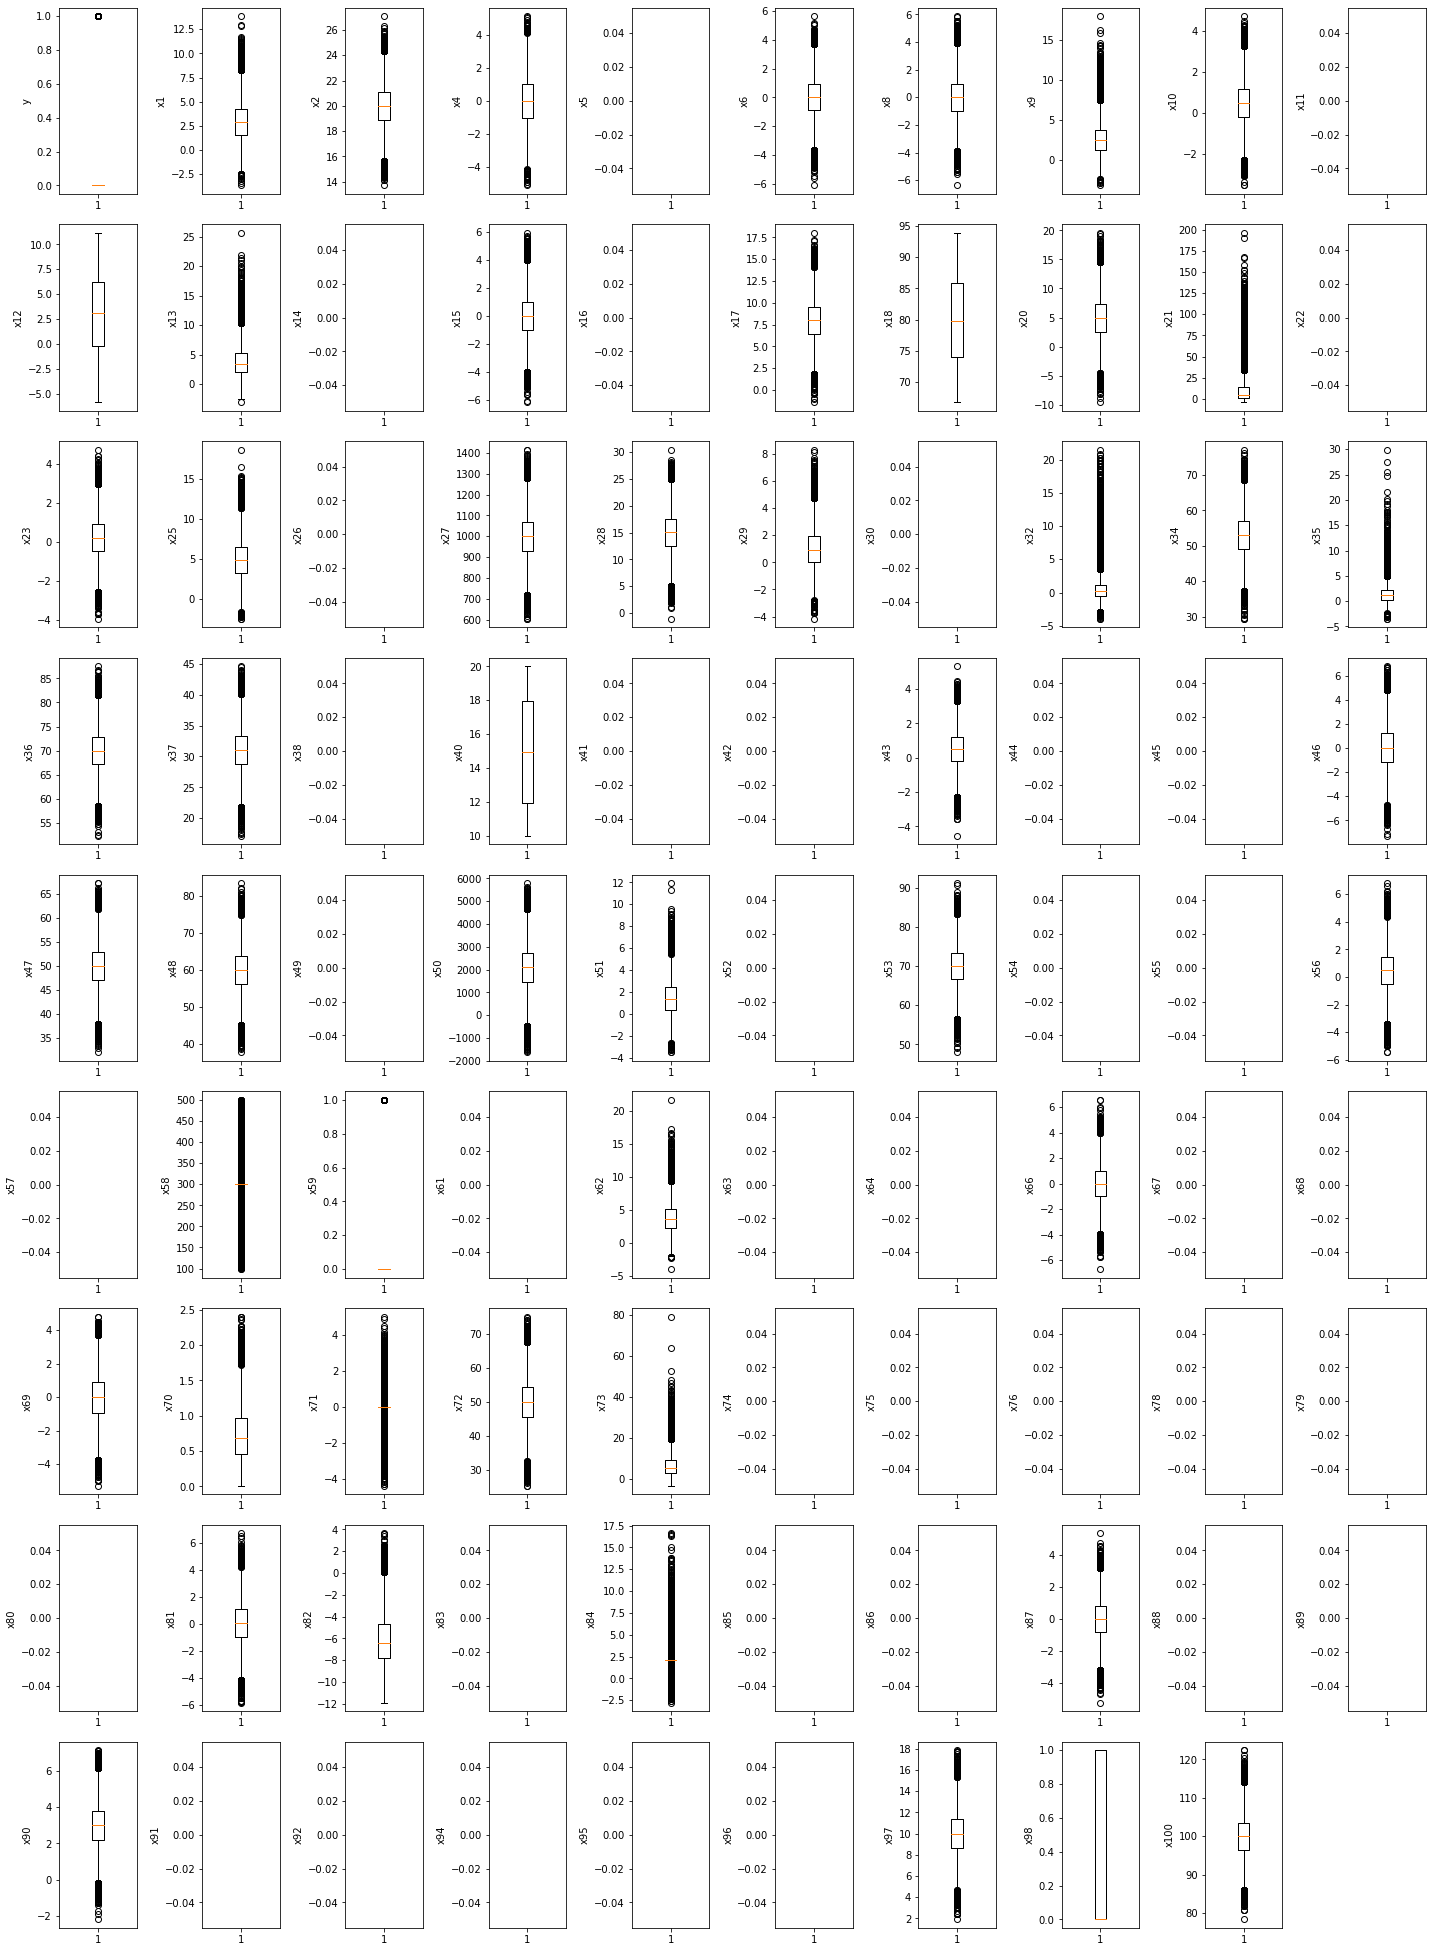

In [46]:
plt.figure(figsize=(20,30))

for i, col in zip(range(1,100), num_list):
    plt.subplot(10,10,i)
    plt.ylabel(col)
    plt.boxplot(df[col], vert=True)
               
plt.tight_layout()
plt.show()

In [47]:
import statsmodels.api as sm
from scipy.stats import norm
import pylab

# plt.figure(figsize=(20,30))

# for i, col in zip(range(1,100), num_list[:5]):
#     #plt.subplot(20,5,i)
#     sm.qqplot(df_num[col], line='45')
#     pylab.show()
   
               
# plt.tight_layout()


In [48]:
#Categorical and Numeric variable list
category_list=[]
num_list=[]
for col in df.columns:
    if df[col].dtype=='object':
        category_list.append(col)
    else:
        num_list.append(col)
        
num_var=df[num_list]

describe = num_var.describe().T
describe['range'] = (num_var.max() - num_var.min()).tolist()
describe['variation coefficient'] = (num_var.std() / num_var.mean()).tolist()
describe['skew'] = num_var.skew().tolist()
describe['kurtosis'] = num_var.kurtosis().tolist()
describe        
        

,count,mean,std,min,25%,50%,75%,max,range,variation coefficient,skew,kurtosis
y,40000.0,0.145075,0.352181,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.427578,2.015685,2.063088
x1,40000.0,2.999958,1.994490,-3.648431,1.592714,2.875892,4.270295,13.837591,17.486022,0.664839,0.382880,0.198652
x2,40000.0,20.004865,1.604291,13.714945,18.921388,20.005944,21.083465,27.086468,13.371523,0.080195,0.010218,-0.005302
x4,40000.0,0.002950,1.462185,-5.137161,-1.026798,0.002263,1.043354,5.150153,10.287314,495.650951,0.007023,-0.328269
x5,37572.0,0.005396,1.297952,-5.616412,-0.872354,0.008822,0.892467,5.698128,11.314540,240.536141,-0.005447,-0.001788
...,...,...,...,...,...,...,...,...,...,...,...,...
x95,27396.0,0.031886,1.823091,-6.885150,-1.190682,0.001523,1.248742,7.631773,14.516923,57.175635,0.049023,0.009103
x96,33362.0,10.525530,1.437581,8.210456,9.397548,10.358355,11.448559,18.725468,10.515012,0.136580,0.632746,0.118909
x97,40000.0,10.002814,1.986984,1.911272,8.665103,9.994318,11.342574,17.861580,15.950308,0.198642,0.019503,0.037706
x98,40000.0,0.497650,0.500001,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.004724,0.009400,-2.000012


In [49]:
high_skew = []

df_num_indep=df_num.drop(["y"], axis=1)

for i, col in enumerate(df_num_indep.columns):    
    if df_num_indep.skew()[i]>1 or df_num_indep.skew()[i]<-1:
        high_skew.append(col)


In [50]:
print(high_skew)

['x13', 'x21', 'x32', 'x35', 'x44', 'x59', 'x67', 'x73', 'x75', 'x79', 'x84', 'x89']


In [52]:
# separating X and y variables
X =df.drop("y", axis=1)
y = df.loc[:,"y"].values.ravel()

In [53]:
#Sampling
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=20)

In [54]:
X_train_num=X_train.select_dtypes(exclude=['object'])
X_train_cat=X_train.select_dtypes(include=['object'])
X_test_num=X_test.select_dtypes(exclude=['object'])
X_test_cat=X_test.select_dtypes(include=['object'])

In [55]:

num_imputer = SimpleImputer(missing_values=np.nan, strategy='mean')
cat_imputer= SimpleImputer(missing_values=np.nan, strategy="most_frequent")

num_mean_imputer = num_imputer.fit(X_train_num)
cat_mean_imputer= cat_imputer.fit(X_train_cat)

X_train_inum = num_mean_imputer.transform(X_train_num)

X_test_inum=num_mean_imputer.transform(X_test_num)


In [56]:
X['x3'].head()

0         Wed
1      Friday
2    Thursday
3     Tuesday
4      Sunday
Name: x3, dtype: object

In [57]:
#ct.fit_transform(X)

In [58]:
# x3_pipe = make_pipeline(x3_week_fun, SimpleImputer(strategy="most_frequent"), OneHotEncoder())
# ct = make_column_transformer((x3_pipe, ['x3']))
# ct.fit_transform(X).toarray()[0].size

In [59]:
#ct.fit_transform(df).toarray()[0].size


# Coulmn Transform  and Pipelines

In [60]:
## Functions and tranformation 

In [61]:

def week_day(df):    
    df['x3']=df['x3'].replace(['Mon','Tue', 'Wed','Thur','Fri','Sat','Sun'],['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday',
                            'Sunday'])    
    return df

x3_week_fun=FunctionTransformer(week_day)     

In [62]:
def col_x7(df):
    df = df.apply(lambda x: x.str.replace('%',""))

    return (np.float_(df))


In [63]:
def col_x19(df):
    df = df.apply(lambda x: x.str.replace('$',""))

    return (np.float_(df))


In [64]:
class columnDropperTransformer():
    def __init__(self,columns):
        self.columns=columns

    def transform(self,X,y=None):
        return X.drop(self.columns,axis=1)

    def fit(self, X, y=None):
        return self 

In [65]:
# x3 pipeline
x3_pipe = Pipeline([('x3_week_fun', x3_week_fun), 
                   ('simple_imputer', SimpleImputer(strategy="most_frequent")), 
                   ('ohe', OneHotEncoder())])

In [66]:
cat_var_pipe = Pipeline([('simple_imputer', SimpleImputer(strategy="most_frequent")), 
                                                     ('ohe',OneHotEncoder())])

In [67]:
# numeric columns with skewness pipeline
num_skewness_pipe = Pipeline([('simple_imputer',SimpleImputer(strategy="mean")), 
                               ('scaler',StandardScaler()),
                                ('pow_tf',PowerTransformer())])

In [68]:
# custom x7 pipeline
col_x7_tf = FunctionTransformer(col_x7)
x7_pipe=Pipeline([('col_x7_tf',col_x7_tf ),
                ('scaler',StandardScaler())])
# custom x19 pipeline
col_x19_tf = FunctionTransformer(col_x19)
x19_pipe=Pipeline([('col_x19_tf',col_x19_tf ),
                ('scaler',StandardScaler())])


In [69]:
#['x13', 'x22', 'x34', 'x36', 'x45', 'x61', 'x68', 'x74', 'x76', 'x80', 'x85', 'x90']
non_skew_num_var = []
for col in df.select_dtypes(exclude=['object']):
    if col not in  ['y','x13', 'x22', 'x34', 'x36', 'x45', 'x61', 'x68', 'x74', 'x76', 'x80', 'x85', 'x90']:
        non_skew_num_var.append(col)
        
print(non_skew_num_var)  

['x1', 'x2', 'x4', 'x5', 'x6', 'x8', 'x9', 'x10', 'x11', 'x12', 'x14', 'x15', 'x16', 'x17', 'x18', 'x20', 'x21', 'x23', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x32', 'x35', 'x37', 'x38', 'x40', 'x41', 'x42', 'x43', 'x44', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51', 'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x62', 'x63', 'x64', 'x66', 'x67', 'x69', 'x70', 'x71', 'x72', 'x73', 'x75', 'x78', 'x79', 'x81', 'x82', 'x83', 'x84', 'x86', 'x87', 'x88', 'x89', 'x91', 'x92', 'x94', 'x95', 'x96', 'x97', 'x98', 'x100']


In [70]:
# Non_Skew columns transfer pipeline

non_skew_numeric_var_pipe = Pipeline([('imp',SimpleImputer(strategy="mean")), 
                               ('scaler',StandardScaler())
                                     ])


In [71]:
#columns with more than 60 % null value
null_col=['x30','x44','x57','x39','x99']

In [72]:
# null columns tranfer pipeline

null_pipe = Pipeline([
    ("columnDropper", columnDropperTransformer(null_col))
])

In [73]:

preprocessor = make_column_transformer(
                             # categorical features : null values handeling , OneHotEncoding 
                            (x3_pipe, ['x3']),
                            (cat_var_pipe, ['x24','x31','x33','x60','x65','x77','x93']),
    
                             # categorical features: text process and transform to numerical features
                             (x7_pipe, ['x7']),
                             (x19_pipe, ['x19']),
                            
                             
                             # Numeric features with high skewness 
                            (num_skewness_pipe, ['x13', 'x22', 'x34', 'x36', 'x45', 'x61', 'x68', 'x74', 'x76', 'x80', 'x85', 'x90']),
                                                         
                             
                             # Remaing numeric features
                             (non_skew_numeric_var_pipe, non_skew_num_var),
                                       
                             #drop column with more than 60% null         
                             (null_pipe, null_col)
                             )



In [74]:
data=pd.read_csv("exercise_40_train.csv")

In [75]:
#drop--'x30','x44','x57'- null values and 'x39','x99'- same value
X= data.drop(['y'], axis=1)
y = data['y']

In [76]:
X.columns

Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',
       'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21',
       'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31',
       'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'x38', 'x39', 'x40', 'x41',
       'x42', 'x43', 'x44', 'x45', 'x46', 'x47', 'x48', 'x49', 'x50', 'x51',
       'x52', 'x53', 'x54', 'x55', 'x56', 'x57', 'x58', 'x59', 'x60', 'x61',
       'x62', 'x63', 'x64', 'x65', 'x66', 'x67', 'x68', 'x69', 'x70', 'x71',
       'x72', 'x73', 'x74', 'x75', 'x76', 'x77', 'x78', 'x79', 'x80', 'x81',
       'x82', 'x83', 'x84', 'x85', 'x86', 'x87', 'x88', 'x89', 'x90', 'x91',
       'x92', 'x93', 'x94', 'x95', 'x96', 'x97', 'x98', 'x99', 'x100'],
      dtype='object')

# Logistic Regression

In [77]:
print(y.value_counts(normalize=True)*100)
#approx 6:1

0    85.4925
1    14.5075
Name: y, dtype: float64


In [78]:
w = {0:1, 1:6}
lg = LogisticRegression(class_weight=w, random_state=20)

LG_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                             ('classiffier', lg)])

LG_pipe.fit(X,y)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('x3_week_fun',
                                                                   FunctionTransformer(func=<function week_day at 0x0000028B63EC9F70>)),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['x3']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequ...
                

In [79]:
lg_y_pred = LG_pipe.predict(X)
print(f'Accuracy Score: {accuracy_score(y,lg_y_pred)}')


Accuracy Score: 0.68835


In [80]:
lg_cm=confusion_matrix(y,lg_y_pred)
lg_cr=classification_report(y,lg_y_pred)
print(lg_cm,"\n")
print(lg_cr)

[[23393 10804]
 [ 1662  4141]] 

              precision    recall  f1-score   support

           0       0.93      0.68      0.79     34197
           1       0.28      0.71      0.40      5803

    accuracy                           0.69     40000
   macro avg       0.61      0.70      0.59     40000
weighted avg       0.84      0.69      0.73     40000



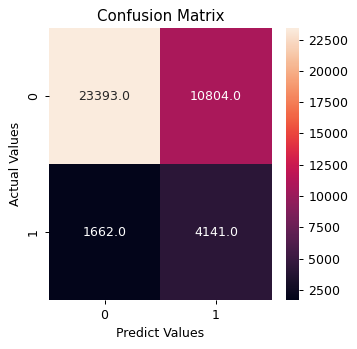

In [99]:
# plotting confusion metrix
plt.figure(figsize=(4,4), dpi=90)
sns.heatmap(lg_cm, annot=True, fmt=".1f")
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predict Values")
plt.show()

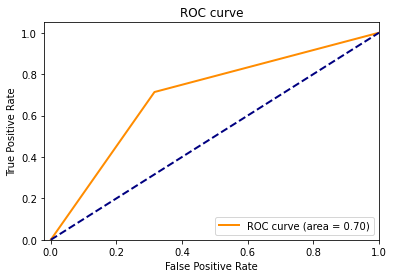

In [82]:
plot_roc_curve(y,lg_y_pred)

# XG Boost

In [83]:
xgb=XGBClassifier( scale_pos_weight=6,eval_metric='mlogloss',n_estimators=150, learning_rate=1, max_depth=3, random_state=20)

In [84]:
XGB_pipe = Pipeline(steps=[('preprocessor', preprocessor),
                             
                             ('classiffier', xgb)])

XGB_pipe.fit(X,y)


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('pipeline-1',
                                                  Pipeline(steps=[('x3_week_fun',
                                                                   FunctionTransformer(func=<function week_day at 0x0000028B63EC9F70>)),
                                                                  ('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder())]),
                                                  ['x3']),
                                                 ('pipeline-2',
                                                  Pipeline(steps=[('simple_imputer',
                                                                   SimpleImputer(strategy='most_frequ...
                

In [85]:
y_pred = XGB_pipe.predict(X)
print(f'Accuracy Score: {accuracy_score(y,y_pred)}')


Accuracy Score: 0.84045


In [86]:
# Evaluation 

xgb_cm=confusion_matrix(y,y_pred)
xgb_cr=classification_report(y,y_pred)
print(xgb_cm,"\n")
print(xgb_cr)


[[28328  5869]
 [  513  5290]] 

              precision    recall  f1-score   support

           0       0.98      0.83      0.90     34197
           1       0.47      0.91      0.62      5803

    accuracy                           0.84     40000
   macro avg       0.73      0.87      0.76     40000
weighted avg       0.91      0.84      0.86     40000



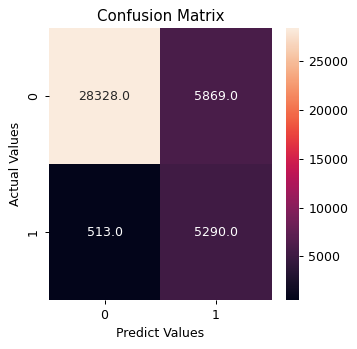

In [100]:
# plotting confusion metrix
plt.figure(figsize=(4,4), dpi=90)
sns.heatmap(xgb_cm, annot=True, fmt=".1f")
plt.title("Confusion Matrix")
plt.ylabel("Actual Values")
plt.xlabel("Predict Values")
plt.show()

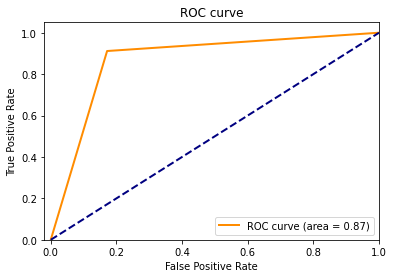

In [88]:
plot_roc_curve(y,y_pred)

## TEST DATA: Class probabilities predictions

In [89]:
df_test = pd.read_csv("test.csv")

In [93]:
lg_glmresults = LG_pipe.predict_proba(df_test)
lg_glmresults_pos = lg_glmresults[:,1]


lg_glmresults_df = pd.DataFrame(lg_glmresults_pos)
lg_glmresults_df.to_csv("glmres.csv", index = False,header=False)

In [94]:
xgb_nonglmresults = XGB_pipe.predict_proba(df_test)
xgb_nonglmresults_pos = xgb_nonglmresults[:,1]

xgb_nonglmresults_df = pd.DataFrame(xgb_nonglmresults_pos)
xgb_nonglmresults_df.to_csv("nonglmres.csv",index = False,header=False)

In [97]:
lg_glmresults

array([[0.86296392, 0.13703608],
       [0.68975745, 0.31024255],
       [0.33248135, 0.66751865],
       ...,
       [0.49573491, 0.50426509],
       [0.30500939, 0.69499061],
       [0.88682583, 0.11317417]])